In [1]:
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.grid_search import GridSearchCV

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [10]:
def modelfit(alg, feature_names, X_train, y_train, X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    #Fit the algorithm on the data
    alg.fit(X_train, y_train)

    #Predict training set:
    y_predictions = alg.predict(X_test)
#     dtrain_predprob = alg.predict_proba(y_test)

    #Print model report:
    print("\nModel Report")
    print("RMSE : %.4g" % metrics.mean_squared_error(y_test, y_predictions))
    #print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp = feat_imp.rename(lambda x: feature_names[int(x[1:len(x)])])
    
    feat_imp.plot(kind='barh', title='Feature Importances',figsize=(7, 16))
    plt.ylabel('Feature Importance Score')

In [5]:
def ModelParamSearch(xgb, params, X_train, y_train):
    search = GridSearchCV(estimator=xgb, param_grid=params, n_jobs=4, iid=False, cv=5)
    search.fit(X_train, y_train)
    print('\ngrid_scores')
    for score in search.grid_scores_:
        print(score)
    print('\nbest_params')
    print(search.best_params_)
    print('\nbest_score')
    print(search.best_score_)
    return search

In [14]:
X_train_df = pd.read_csv("../data/offline/X_train.csv", index_col=0)
y_train_df = pd.read_csv("../data/offline/y_train.csv", index_col=0)
X_test_df = pd.read_csv("../data/offline/X_test.csv", index_col=0)
combine_df = pd.concat([X_train_df, X_test_df])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df.values, y_train_df['SalePrice'].values, test_size=0.5, random_state=1729)

In [16]:
feature_names = X_train_df.columns


Model Report
RMSE : 0.02124


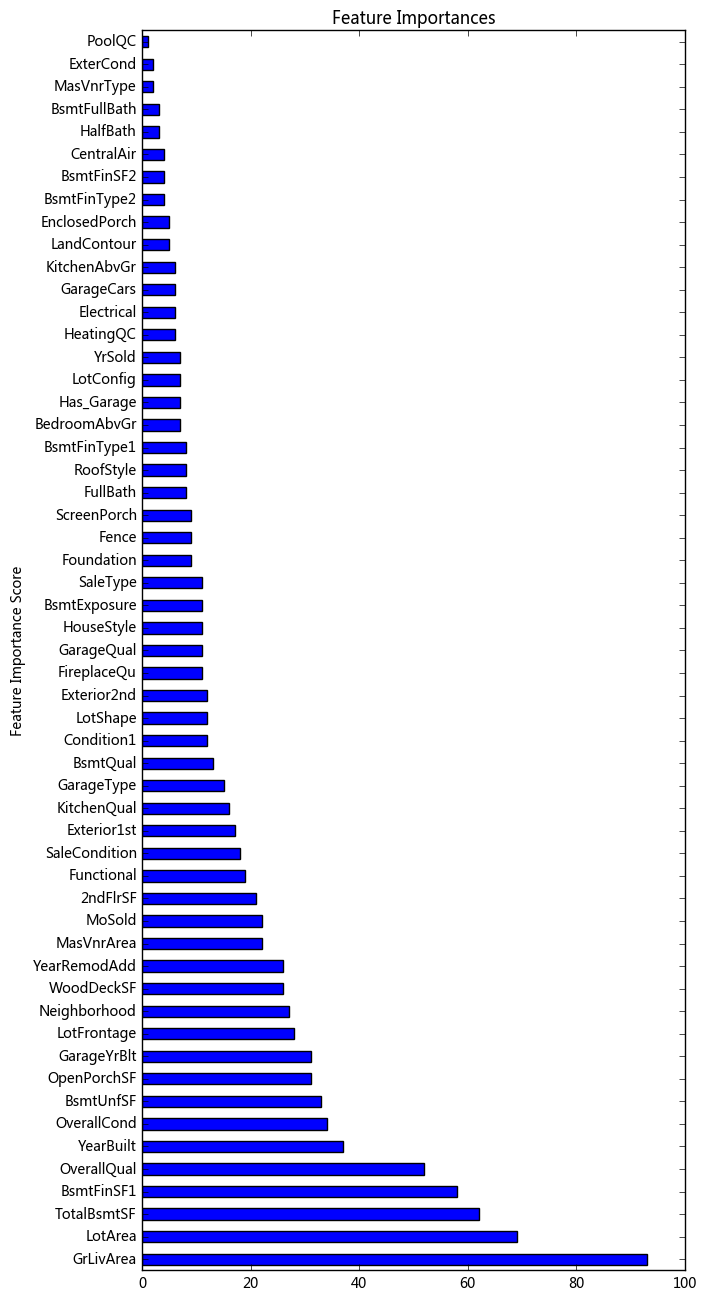

In [17]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.8,\
                             colsample_bytree=0.8, gamma=0, min_child_weight = 1,\
                             scale_pos_weight=1, seed=27)

modelfit(xgb_model, feature_names, X_train, y_train, X_test, y_test)
plt.show()

In [18]:
xgb_model = xgb.XGBRegressor(max_depth=2, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.8,\
                             colsample_bytree=0.75, gamma=0, min_child_weight = 6,\
                             scale_pos_weight=1, seed=27)

params1 = {
 'max_depth':np.array(range(3,10,2)),
 'min_child_weight':np.array(range(1,6,2))
}
search = ModelParamSearch(xgb_model, params1, X_train, y_train)


grid_scores
mean: 0.88414, std: 0.01669, params: {'min_child_weight': 1, 'max_depth': 3}
mean: 0.88760, std: 0.01846, params: {'min_child_weight': 3, 'max_depth': 3}
mean: 0.89054, std: 0.01842, params: {'min_child_weight': 5, 'max_depth': 3}
mean: 0.88310, std: 0.01807, params: {'min_child_weight': 1, 'max_depth': 5}
mean: 0.88620, std: 0.02060, params: {'min_child_weight': 3, 'max_depth': 5}
mean: 0.89234, std: 0.01736, params: {'min_child_weight': 5, 'max_depth': 5}
mean: 0.88207, std: 0.01715, params: {'min_child_weight': 1, 'max_depth': 7}
mean: 0.88644, std: 0.01644, params: {'min_child_weight': 3, 'max_depth': 7}
mean: 0.89082, std: 0.01489, params: {'min_child_weight': 5, 'max_depth': 7}
mean: 0.88053, std: 0.01904, params: {'min_child_weight': 1, 'max_depth': 9}
mean: 0.88773, std: 0.01958, params: {'min_child_weight': 3, 'max_depth': 9}
mean: 0.89151, std: 0.01473, params: {'min_child_weight': 5, 'max_depth': 9}

best_params
{'min_child_weight': 5, 'max_depth': 5}

best_scor

In [19]:
params = {
 'max_depth':[4, 5, 6],
 'min_child_weight':[4, 5, 6]
}
search2 = ModelParamSearch(xgb_model, params, X_train, y_train)

# 0.8959456941803028
# 0.8938496041827715


grid_scores
mean: 0.89150, std: 0.01666, params: {'min_child_weight': 4, 'max_depth': 4}
mean: 0.89385, std: 0.01612, params: {'min_child_weight': 5, 'max_depth': 4}
mean: 0.89350, std: 0.02109, params: {'min_child_weight': 6, 'max_depth': 4}
mean: 0.89251, std: 0.01627, params: {'min_child_weight': 4, 'max_depth': 5}
mean: 0.89234, std: 0.01736, params: {'min_child_weight': 5, 'max_depth': 5}
mean: 0.89230, std: 0.01796, params: {'min_child_weight': 6, 'max_depth': 5}
mean: 0.89019, std: 0.01761, params: {'min_child_weight': 4, 'max_depth': 6}
mean: 0.89292, std: 0.01537, params: {'min_child_weight': 5, 'max_depth': 6}
mean: 0.89165, std: 0.01836, params: {'min_child_weight': 6, 'max_depth': 6}

best_params
{'min_child_weight': 5, 'max_depth': 4}

best_score
0.8938496041827715


In [20]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.8,\
                             colsample_bytree=0.75, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27)

params3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}


search3 = ModelParamSearch(xgb_model, params3, X_train, y_train)

# best_params
# {'gamma': 0.0}

# best_score
# 0.8977214764046604


grid_scores
mean: 0.89385, std: 0.01612, params: {'gamma': 0.0}
mean: 0.88530, std: 0.01783, params: {'gamma': 0.1}
mean: 0.87449, std: 0.01539, params: {'gamma': 0.2}
mean: 0.86503, std: 0.01529, params: {'gamma': 0.3}
mean: 0.85654, std: 0.01944, params: {'gamma': 0.4}

best_params
{'gamma': 0.0}

best_score
0.8938496041827715


In [26]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.55,\
                             colsample_bytree=0.7, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27, reg_alpha=1e-07)

param4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

search4 = ModelParamSearch(xgb_model, param4, X_train, y_train)

# best_params
# {'colsample_bytree': 0.7, 'subsample': 0.7}

# best_score
# 0.9001576485029655


grid_scores
mean: 0.89440, std: 0.01471, params: {'colsample_bytree': 0.6, 'subsample': 0.6}
mean: 0.89633, std: 0.01653, params: {'colsample_bytree': 0.6, 'subsample': 0.7}
mean: 0.88981, std: 0.01822, params: {'colsample_bytree': 0.6, 'subsample': 0.8}
mean: 0.89347, std: 0.01814, params: {'colsample_bytree': 0.6, 'subsample': 0.9}
mean: 0.89003, std: 0.01817, params: {'colsample_bytree': 0.7, 'subsample': 0.6}
mean: 0.89563, std: 0.01667, params: {'colsample_bytree': 0.7, 'subsample': 0.7}
mean: 0.88856, std: 0.01788, params: {'colsample_bytree': 0.7, 'subsample': 0.8}
mean: 0.89095, std: 0.01805, params: {'colsample_bytree': 0.7, 'subsample': 0.9}
mean: 0.89310, std: 0.01439, params: {'colsample_bytree': 0.8, 'subsample': 0.6}
mean: 0.89423, std: 0.01756, params: {'colsample_bytree': 0.8, 'subsample': 0.7}
mean: 0.88911, std: 0.01967, params: {'subsample': 0.8, 'colsample_bytree': 0.8}
mean: 0.88858, std: 0.01846, params: {'colsample_bytree': 0.8, 'subsample': 0.9}
mean: 0.89193, 

In [22]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.8,\
                             colsample_bytree=0.75, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27)

param5 = {
 'subsample':[i/100.0 for i in range(55,70,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}

search5 = ModelParamSearch(xgb_model, param5, X_train, y_train)


# best_params
# {'colsample_bytree': 0.65, 'subsample': 0.65}

# best_score
# 0.9007344923004951


grid_scores
mean: 0.89289, std: 0.01228, params: {'colsample_bytree': 0.65, 'subsample': 0.55}
mean: 0.89524, std: 0.01489, params: {'subsample': 0.6, 'colsample_bytree': 0.65}
mean: 0.89261, std: 0.01493, params: {'colsample_bytree': 0.65, 'subsample': 0.65}
mean: 0.89732, std: 0.01700, params: {'colsample_bytree': 0.7, 'subsample': 0.55}
mean: 0.89003, std: 0.01817, params: {'subsample': 0.6, 'colsample_bytree': 0.7}
mean: 0.89185, std: 0.02034, params: {'colsample_bytree': 0.7, 'subsample': 0.65}
mean: 0.89129, std: 0.01534, params: {'colsample_bytree': 0.75, 'subsample': 0.55}
mean: 0.89267, std: 0.01740, params: {'colsample_bytree': 0.75, 'subsample': 0.6}
mean: 0.89172, std: 0.01874, params: {'colsample_bytree': 0.75, 'subsample': 0.65}

best_params
{'colsample_bytree': 0.7, 'subsample': 0.55}

best_score
0.8973179880993458


In [23]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.55,\
                             colsample_bytree=0.7, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27)

param6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

search6 = ModelParamSearch(xgb_model, param6, X_train, y_train)


# best_params
# {'reg_alpha': 1}

# best_score
# 0.9008283650864461


grid_scores
mean: 0.89732, std: 0.01700, params: {'reg_alpha': 1e-05}
mean: 0.89618, std: 0.01543, params: {'reg_alpha': 0.01}
mean: 0.89370, std: 0.01799, params: {'reg_alpha': 0.1}
mean: 0.88932, std: 0.01812, params: {'reg_alpha': 1}
mean: -0.36256, std: 0.13573, params: {'reg_alpha': 100}

best_params
{'reg_alpha': 1e-05}

best_score
0.8973178976959362


In [24]:
param7 = {
 'reg_alpha':[1e-07, 1e-05, 1e-03]
}

search7 = ModelParamSearch(xgb_model, param7, X_train, y_train)


# best_params
# {'reg_alpha': 1.1}

# best_score
# 0.9009523929423489


grid_scores
mean: 0.89732, std: 0.01700, params: {'reg_alpha': 1e-07}
mean: 0.89732, std: 0.01700, params: {'reg_alpha': 1e-05}
mean: 0.89626, std: 0.01621, params: {'reg_alpha': 0.001}

best_params
{'reg_alpha': 1e-07}

best_score
0.8973180045231768



Model Report
RMSE : 0.02168


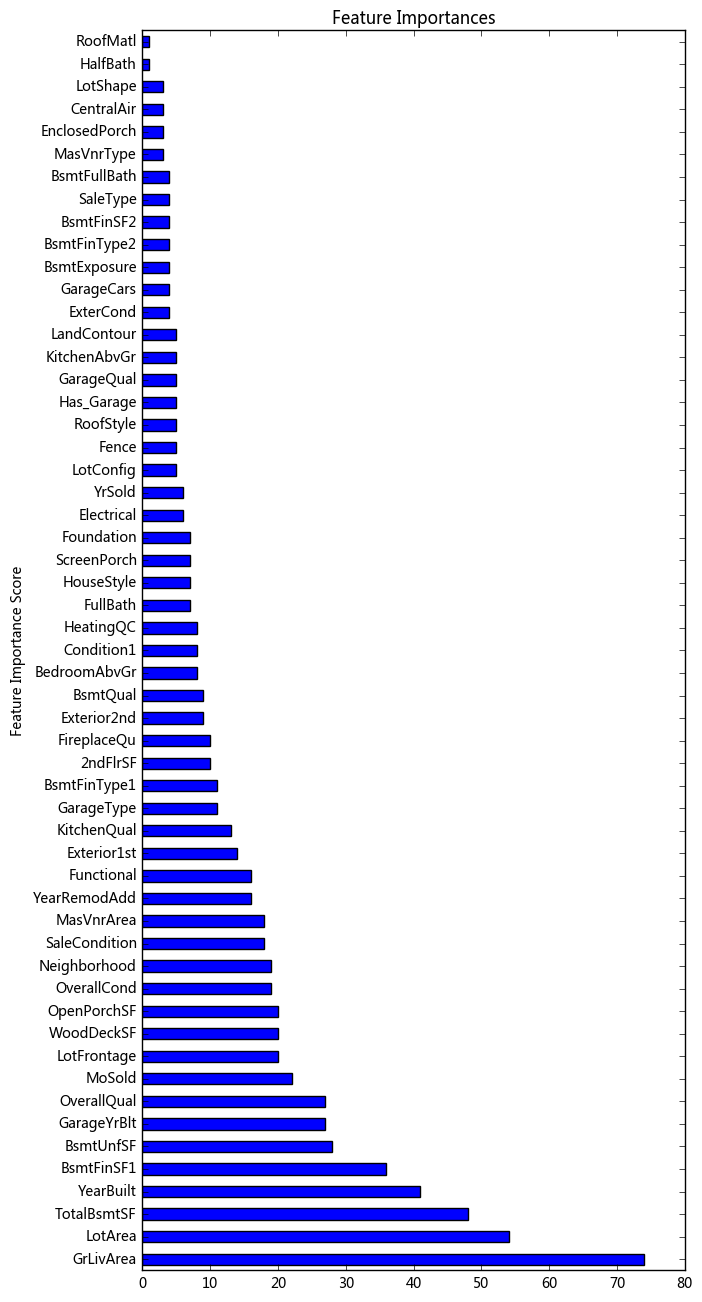

In [25]:
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100,\
                             silent=False, objective='reg:linear', subsample=0.55,\
                             colsample_bytree=0.7, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27, reg_alpha=1e-07)

modelfit(xgb_model, feature_names, X_train, y_train, X_test, y_test)
plt.show()

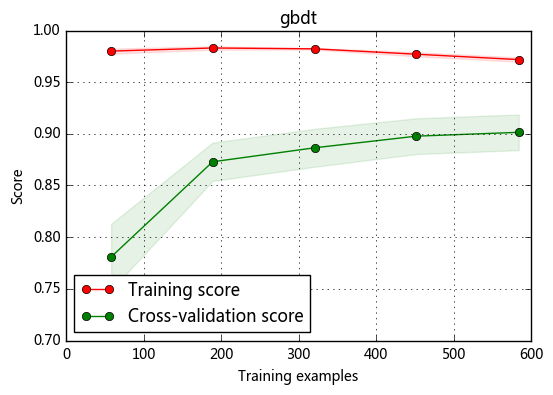

In [29]:
#gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=Nonemax_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='reg:linear', booster='gbtree', nthread=-1, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None
xgb_model = xgb.XGBRegressor(max_depth=4, learning_rate=0.01, n_estimators=1000,\
                             silent=False, objective='reg:linear', subsample=0.55,\
                             colsample_bytree=0.7, gamma=0, min_child_weight = 5,\
                             scale_pos_weight=1, seed=27, reg_alpha=1e-07)
plot_learning_curve(xgb_model, 'gbdt', X_train, y_train, cv=5)
plt.show()

In [30]:
xgb_model.fit(X_train, y_train)
xgb_model.score(X_test, y_test)

0.87873438659299097

In [31]:
0.87161084260404043

0.8716108426040404

In [32]:
X_train_df.columns

Index(['GrLivArea', 'OverallQual', 'BsmtFinSF1', 'GarageQual', 'Electrical',
       'TotalBsmtSF', 'LotShape', 'LotArea', 'LotFrontage', 'LandContour',
       'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'HouseStyle',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterCond',
       'Foundation', 'Has_Bsmt', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'HeatingQC', 'CentralAir',
       '2ndFlrSF', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'Functional', 'FireplaceQu',
       'Has_Garage', 'GarageType', 'GarageYrBlt', 'GarageCars', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC',
       'Fence', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'],
      dtype='object')

In [33]:
y_predict = xgb_model.predict(X_test_df.values)

In [34]:
y_predict_df = pd.DataFrame(y_predict, index=X_test_df.index)
y_predict_df = y_predict_df.rename(columns={0:'SalePrice'})

In [35]:
y_predict_df['SalePrice'] = np.power(np.e, y_predict_df['SalePrice']) - 1
y_predict_df.to_csv('../data/online/predict.csv', header = True, index=True)

In [36]:
y_predict_df['SalePrice']

Id
1461    128961.679688
1462    173579.296875
1463    175055.359375
1464    184582.984375
1465    200281.640625
1466    169961.265625
1467    175304.453125
1468    166267.468750
1469    188176.375000
1470    124515.625000
1471    202315.781250
1472     98320.593750
1473     97408.750000
1474    149749.484375
1475    127870.125000
1476    377557.156250
1477    253329.953125
1478    300071.625000
1479    282025.312500
1480    465061.593750
1481    311954.343750
1482    210954.984375
1483    167024.765625
1484    166044.515625
1485    175079.562500
1486    194756.359375
1487    306169.531250
1488    231002.656250
1489    189727.531250
1490    215213.187500
            ...      
2890     85844.750000
2891    143150.515625
2892     50335.191406
2893     81547.085938
2894     62345.875000
2895    292032.812500
2896    268801.562500
2897    206196.750000
2898    157090.843750
2899    228165.109375
2900    158005.718750
2901    191836.421875
2902    188046.125000
2903    352529.562500
2904   